## Imports

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

In [106]:
df = pd.read_csv('train.csv')
df.dropna(subset=['value_eur'], inplace=True)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15333 entries, 0 to 15390
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   15333 non-null  int64  
 1   id                           15333 non-null  int64  
 2   short_name                   15333 non-null  object 
 3   long_name                    15333 non-null  object 
 4   player_positions             15333 non-null  object 
 5   overall                      15333 non-null  int64  
 6   potential                    15333 non-null  int64  
 7   value_eur                    15333 non-null  float64
 8   wage_eur                     15333 non-null  float64
 9   age                          15333 non-null  int64  
 10  dob                          15333 non-null  object 
 11  height_cm                    15333 non-null  int64  
 12  weight_kg                    15333 non-null  int64  
 13  club_team_id         

## Drop irrelevant columns

In [108]:
cols_to_drop = ['Unnamed: 0', 'id', 'short_name', "long_name", "dob", "club_jersey_number", "nation_jersey_number", "club_name", "club_loaned_from", "nation_position", "player_traits", "player_tags", "nationality_name"]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

## Contract-related variable manipulation

In [109]:
start_date = float(2021) # year when dataset was recorded 
df["years_left_contract"] = df["club_contract_valid_until"] - start_date

df['club_joined'] = pd.to_datetime(df['club_joined'], format='%Y-%m-%d')
df["years_in_club"] = start_date - df["club_joined"].dt.year

In [110]:
df.drop(columns=["club_contract_valid_until", "club_joined"], inplace=True, errors='ignore')

## Work rate split

In [111]:
df[["work_attack", "work_defense"]] = df["work_rate"].str.split("/", expand=True)
maps = {"Low": 1, "Medium": 2, "High": 3}
df["work_attack"] = df["work_attack"].map(maps)
df["work_defense"] = df["work_defense"].map(maps)

In [112]:
df["primary_position"] = df["player_positions"].str.split(",", expand=True)[0]

## Grouping Technical Attributes

In [113]:
#Attacking attributes score
df["attacking_score"] = df[[
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "attacking_volleys"
]].mean(axis=1)

In [114]:
#Skills attributes score
df["skills_score"] = df[[
    "skill_dribbling",
    "skill_curve",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control"
]].mean(axis=1)

In [115]:
# Movement attributes score
df["movement_score"] = df[[
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_agility",
    "movement_reactions",
    "movement_balance"
]].mean(axis=1)

In [116]:
# Power attributes score
df["power_score"] = df[[
    "power_shot_power",
    "power_jumping",
    "power_stamina",
    "power_strength",
    "power_long_shots"
]].mean(axis=1)

In [117]:
# Mentality attributes score
df["mentality_score"] = df[[
    "mentality_aggression",
    "mentality_interceptions",
    "mentality_positioning",
    "mentality_vision",
    "mentality_penalties",
    "mentality_composure"
]].mean(axis=1)

In [118]:
# Defending technical attributes score
df["defending_technical_score"] = df[[
    "defending_marking_awareness",
    "defending_standing_tackle",
    "defending_sliding_tackle"
]].mean(axis=1)

## Starter bool

In [119]:
df["is_starter"] = (~df["club_position"].isin(["SUB", "RES"])).astype(int)

## Multipositional bool

In [120]:
df["multiple_positions"] = df["player_positions"].str.split(",").apply(lambda x: len(x) > 1).astype(int)

## Handle Missing Data

In [121]:
null_columns = df.columns[df.isnull().any()]
print(null_columns)

Index(['release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling',
       'defending', 'physic', 'goalkeeping_speed', 'years_in_club'],
      dtype='object')


In [122]:
df["years_in_club"] = df['years_in_club'].fillna(df['years_in_club'].mean())
df['release_clause_eur'] = df['release_clause_eur'].fillna(df['release_clause_eur'].median())
df['pace'] = df['pace'].fillna(0)
df['shooting'] = df['shooting'].fillna(0)
df['passing'] = df['passing'].fillna(0)
df['dribbling'] = df['dribbling'].fillna(0)
df['defending'] = df['defending'].fillna(0)
df['physic'] = df['physic'].fillna(0)
df['goalkeeping_speed'] = df['goalkeeping_speed'].fillna(0)

In [123]:
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].astype('category')

## Median-encoding for club and league

### Train-test split to avoid data leakage

In [124]:
y = df["value_eur"]

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [129]:
median_values_by_club = X_train.groupby("club_team_id")["value_eur"].median().to_dict()
median_league_value = X_train.groupby("league_name", observed=True)["value_eur"].median().to_dict()

In [130]:
X_train['median_club_value'] = X_train['club_team_id'].map(median_values_by_club)
X_test['median_club_value'] = X_test['club_team_id'].map(median_values_by_club)

X_train['median_league_value'] = X_train['league_name'].map(median_league_value)
X_test['median_league_value'] = X_test['league_name'].map(median_league_value)

In [69]:
# X_train.drop(columns=["value_eur"], inplace=True)
# X_test.drop(columns=["value_eur"], inplace=True)

# X_train.drop(columns=["player_positions", "league_name"], inplace=True)
# X_test.drop(columns=["player_positions", "league_name"], inplace=True)

X_train.drop(columns=["club_team_id", "nationality_id"], inplace=True)
X_test.drop(columns=["club_team_id", "nationality_id"], inplace=True)

In [ ]:
# Create DMatrix for training and testing
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Define parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'seed': 42
}

# Train the model
num_round = 1000
model = xgb.train(params, dtrain, num_round)

# Evaluate the model
train_preds = model.predict(dtrain)
test_preds = model.predict(dtest)

train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

/opt/homebrew/Caskroom/miniconda/base/envs/ML/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:51:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train RMSE: 8.862261390688444
Test RMSE: 71906.21509553368


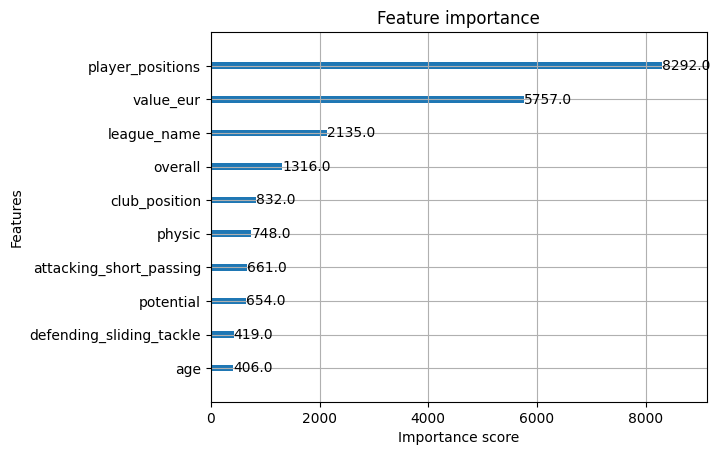

In [137]:
xgb.plot_importance(model, max_num_features=10, importance_type='weight')
plt.show()

In [72]:
# List of columns to keep
cols_to_keep = [
    "overall",
    "club_position",
    "release_clause_eur",
    "potential",
    "wage_eur",
    "age",
    "primary_position",
    "median_league_value",
    "body_type",
    "median_club_value"
]

# Filter the dataset to keep only the specified columns
X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

In [138]:
reg = xgb.XGBRegressor(
    max_depth=100,
    learning_rate=0.1,
    max_cat_to_onehot=5,
    enable_categorical=True,
)
reg.fit(X_train, y_train)

train_preds = reg.predict(X_train)
test_preds = reg.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 5350.108755954241
Test RMSE: 74889.79294589149


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
le = LabelEncoder()

# Fit the LabelEncoder on the categorical columns
for col in X_train.select_dtypes(include=['category']).columns:
    le.fit(X_train[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [89]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12266 entries, 6770 to 7300
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   overall              12266 non-null  int64  
 1   club_position        12266 non-null  int64  
 2   release_clause_eur   12266 non-null  float64
 3   potential            12266 non-null  int64  
 4   wage_eur             12266 non-null  float64
 5   age                  12266 non-null  int64  
 6   primary_position     12266 non-null  int64  
 7   median_league_value  12266 non-null  float64
 8   body_type            12266 non-null  int64  
 9   median_club_value    12266 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 1.3 MB


In [92]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=100,
    random_state=42,
)

rf.fit(X_train, y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 308488.57857480866
Test RMSE: 792059.1573526779


In [95]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.2, 0.25, 0.3, 0.35, 0.4],
    'subsample': [0.5, 0.8, 1.0],
}

# Create the XGBoost regressor
xgb_reg = xgb.XGBRegressor(enable_categorical=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best parameters: {'learning_rate': 0.3, 'max_depth': 3, 'subsample': 1.0}
Best RMSE: 778649.4410681797
